In [1]:
!pip install --upgrade pip
# 各ライブラリインストール
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

# 環境変数設定
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

# findsparkで環境設定
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

# delete files from previous runs
!rm -f hmp.parquet*

# download the file containing the data in PARQUET format
!wget https://github.com/IBM/coursera/raw/master/hmp.parquet
    
# create a dataframe out of it
df = spark.read.parquet('hmp.parquet')

# register a corresponding query table
df.createOrReplaceTempView('df')

     |████████████████████████████████| 1.4MB 4.2MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
--2020-03-31 13:36:50--  https://github.com/IBM/coursera/raw/master/hmp.parquet
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/IBM/skillsnetwork/raw/master/hmp.parquet [following]
--2020-03-31 13:36:51--  https://github.com/IBM/skillsnetwork/raw/master/hmp.parquet
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IBM/skillsnetwork/master/hmp.parquet [following]
--2020-03-31 13:36:51--  https://raw.githubusercontent.com/IBM/skillsnetwork/master/hmp.parquet
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ..

In [14]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, Normalizer
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
indexer = StringIndexer(inputCol="class", outputCol="classIndex")
encoder = OneHotEncoder(inputCol="classIndex", outputCol="categoryVec")
vectorAssembler = VectorAssembler(inputCols=["x","y","z"],
                                  outputCol="features")
normalizer = Normalizer(inputCol="features", outputCol="features_norm", p=1.0)

pipeline = Pipeline(stages=[indexer, encoder, vectorAssembler, normalizer])
model = pipeline.fit(df)
prediction = model.transform(df)
prediction.show()

+---+---+---+--------------------+-----------+----------+--------------+----------------+--------------------+
|  x|  y|  z|              source|      class|classIndex|   categoryVec|        features|       features_norm|
+---+---+---+--------------------+-----------+----------+--------------+----------------+--------------------+
| 22| 49| 35|Accelerometer-201...|Brush_teeth|       6.0|(13,[6],[1.0])|[22.0,49.0,35.0]|[0.20754716981132...|
| 22| 49| 35|Accelerometer-201...|Brush_teeth|       6.0|(13,[6],[1.0])|[22.0,49.0,35.0]|[0.20754716981132...|
| 22| 52| 35|Accelerometer-201...|Brush_teeth|       6.0|(13,[6],[1.0])|[22.0,52.0,35.0]|[0.20183486238532...|
| 22| 52| 35|Accelerometer-201...|Brush_teeth|       6.0|(13,[6],[1.0])|[22.0,52.0,35.0]|[0.20183486238532...|
| 21| 52| 34|Accelerometer-201...|Brush_teeth|       6.0|(13,[6],[1.0])|[21.0,52.0,34.0]|[0.19626168224299...|
| 22| 51| 34|Accelerometer-201...|Brush_teeth|       6.0|(13,[6],[1.0])|[22.0,51.0,34.0]|[0.20560747663551...|
|

In [3]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

kmeans = KMeans(featuresCol="features").setK(14).setSeed(1)
pipeline = Pipeline(stages=[vectorAssembler, kmeans])
model = pipeline.fit(df)
predictions = model.transform(df)

evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)

print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.41244594513295846


In [0]:
KMeansList = []

for i in range(2, 15):
  kmeans = KMeans(featuresCol="features").setK(i).setSeed(1)
  pipeline = Pipeline(stages=[vectorAssembler, kmeans])
  model = pipeline.fit(df)
  predictions = model.transform(df)
  evaluator = ClusteringEvaluator()
  silhouette = evaluator.evaluate(predictions)
  KMeansList.append([silhouette])

In [5]:
KMeansList

[[0.6875664014387497],
 [0.6147915951361759],
 [0.6333227654128869],
 [0.5937447997439024],
 [0.592463658820136],
 [0.5484627422401509],
 [0.46686489256383346],
 [0.48034893889849645],
 [0.47370428136987536],
 [0.4819049717562352],
 [0.40964155503229643],
 [0.4153293521373778],
 [0.41244594513295846]]

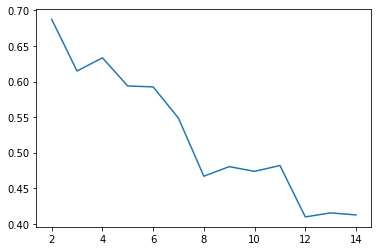

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

left = np.array(range(2,15))
height = np.array(KMeansList)
plt.xlabel = 'k'
plt.ylabel = 'silhouette'
plt.plot(left, height)

In [17]:
df.show()

+---+---+---+--------------------+-----------+
|  x|  y|  z|              source|      class|
+---+---+---+--------------------+-----------+
| 22| 49| 35|Accelerometer-201...|Brush_teeth|
| 22| 49| 35|Accelerometer-201...|Brush_teeth|
| 22| 52| 35|Accelerometer-201...|Brush_teeth|
| 22| 52| 35|Accelerometer-201...|Brush_teeth|
| 21| 52| 34|Accelerometer-201...|Brush_teeth|
| 22| 51| 34|Accelerometer-201...|Brush_teeth|
| 20| 50| 35|Accelerometer-201...|Brush_teeth|
| 22| 52| 34|Accelerometer-201...|Brush_teeth|
| 22| 50| 34|Accelerometer-201...|Brush_teeth|
| 22| 51| 35|Accelerometer-201...|Brush_teeth|
| 21| 51| 33|Accelerometer-201...|Brush_teeth|
| 20| 50| 34|Accelerometer-201...|Brush_teeth|
| 21| 49| 33|Accelerometer-201...|Brush_teeth|
| 21| 49| 33|Accelerometer-201...|Brush_teeth|
| 20| 51| 35|Accelerometer-201...|Brush_teeth|
| 18| 49| 34|Accelerometer-201...|Brush_teeth|
| 19| 48| 34|Accelerometer-201...|Brush_teeth|
| 16| 53| 34|Accelerometer-201...|Brush_teeth|
| 18| 52| 35|

In [29]:
kmeans = KMeans(featuresCol="features_norm").setK(14).setSeed(1)
pipeline = Pipeline(stages=[vectorAssembler, normalizer, kmeans])
model = pipeline.fit(df)

predictions = model.transform(df)

evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)

print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.2668998965895519


In [0]:
from pyspark.sql.functions import col
df_denormalized = df.select([col('*'),(col('x')*10)]).drop('x').withColumnRenamed('(x * 10)','x')

In [34]:
kmeans = KMeans(featuresCol="features").setK(14).setSeed(1)
pipeline = Pipeline(stages=[vectorAssembler, kmeans])
model = pipeline.fit(df_denormalized)
predictions = model.transform(df_denormalized)

evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared eiclidean distance = "+ str(silhouette))

Silhouette with squared eiclidean distance = 0.5709023393004293


In [35]:
from pyspark.ml.clustering import GaussianMixture
gmm = GaussianMixture().setK(14).setSeed(1)
pipeline = Pipeline(stages=[vectorAssembler, gmm])
model = pipeline.fit(df)

predictions = model.transform(df)

evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.15906267433367427
